In [1]:
%pylab inline
import keras
from tqdm import tqdm # nice progress bar

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K20Xm (0000:20:00.0)


# Data preparation

In [2]:
from PIL import Image
from scipy.misc import imread, imresize
from keras.utils.np_utils import to_categorical

import random

class VOCDataset:
    def __init__(self, voc_dir, split, mean, resize_to=(500,500)):
        self.voc_dir = voc_dir
        self.split = split
        self.mean = mean
        self.resize_to = resize_to

        # load indices for images and labels
        split_f  = '{}/ImageSets/Segmentation/{}.txt'.format(self.voc_dir,
                self.split)
        self.indices = open(split_f, 'r').read().splitlines()

    def load_image(self, idx):
        im = Image.open('{}/JPEGImages/{}.jpg'.format(self.voc_dir, idx))
        in_ = imresize(im, self.resize_to)
        in_ = np.array(in_, dtype=np.float32)
        in_ -= self.mean
        return in_

    def load_label(self, idx):
        im = Image.open('{}/SegmentationClass/{}.png'.format(self.voc_dir, idx))
        im = im.resize(self.resize_to)
        label = np.array(im, dtype=np.uint8)
        # QUICK HACK
        label[label==255] = 0
        return to_categorical(label, 21).reshape(self.resize_to[0], self.resize_to[1], 21)
    
    def iterate_minibatches(self, batch_size=20, randomize=True):
        if randomize:
            random.shuffle(self.indices)
            
        for i in range(0, len(self.indices), batch_size):
            X = [ self.load_image(idx) for idx in self.indices[i:i+batch_size] ]
            y = [ self.load_label(idx) for idx in self.indices[i:i+batch_size] ]
            
            yield np.array(X, dtype='float32'), np.array(y, dtype='uint8')


In [3]:
mean=(104.00699, 116.66877, 122.67892)
train = VOCDataset('data/VOC2012', 'train', mean=mean)
val = VOCDataset('data/VOC2012', 'val', mean=mean)

In [4]:
#plt.imshow( (train.load_image(train.indices[0]) + mean).astype('uint8'))

In [5]:
#np.unique(train.load_label(train.indices[0]))

In [6]:
#plt.imshow(train.load_label(train.indices[0]))

# Training

In [35]:
from keras_fcn import FCN_VGG16
fcn_vgg16 = FCN_VGG16(input_shape=(500, 500, 3), classes=21, weights='imagenet', trainable_encoder=False)

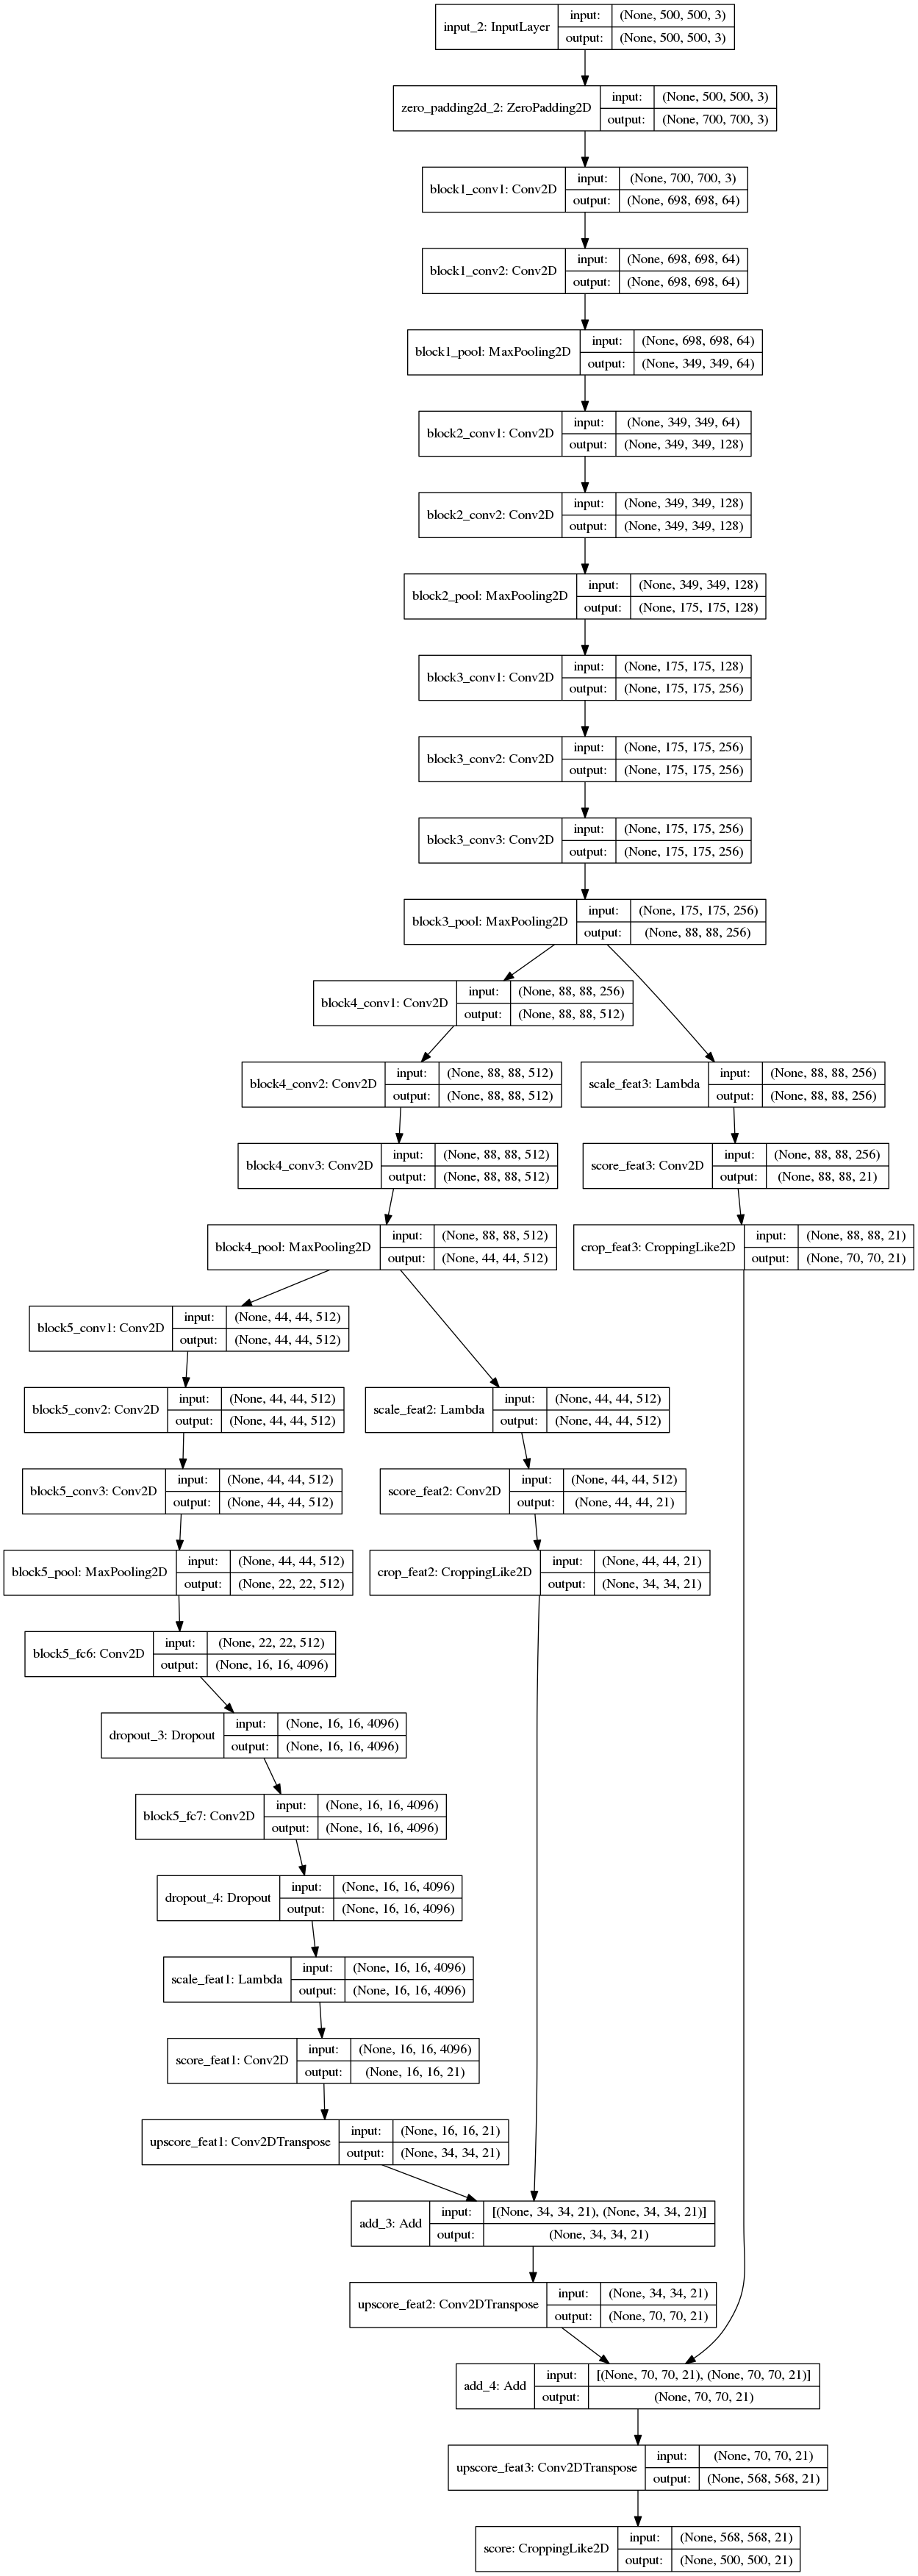

In [36]:
from keras.utils import plot_model
from keras.preprocessing import image
plot_model(fcn_vgg16, show_shapes=True, to_file='imgs/models/fcn_vgg16.png')
image.load_img('imgs/models/fcn_vgg16.png')

In [37]:
from keras.optimizers import SGD, Adam
opt = Adam(lr=1e-4)
fcn_vgg16.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

In [38]:
def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


In [39]:
def init_upsample_layer(layer):
    params = layer.get_weights()    
    h,w,m,k = params[0].shape
    
    assert h==w, m==k

    filt = upsample_filt(h)
    params[0][...] = 0
    for i in range(k):
        params[0][:, :, i, i] = filt[::-1, ::-1]
    
    layer.set_weights(params)
    layer.trainable = False
    assert layer.use_bias == False
    
    print params

In [40]:
for i in range(1, 4):
    l = fcn_vgg16.get_layer('upscore_feat' + str(i))
    init_upsample_layer(l)

[array([[[[ 0.0625,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.0625,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.0625, ...,  0.    ,  0.    ,  0.    ],
         ..., 
         [ 0.    ,  0.    ,  0.    , ...,  0.0625,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.0625,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.0625]],

        [[ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.1875,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.1875, ...,  0.    ,  0.    ,  0.    ],
         ..., 
         [ 0.    ,  0.    ,  0.    , ...,  0.1875,  0.    ,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.1875,  0.    ],
         [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.1875]],

        [[ 0.1875,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
         [ 0.    ,  0.1875,  0.    , ...,  0.    ,  0. 

In [41]:
for l in fcn_vgg16.layers:
    if l.trainable:
        print l.name

zero_padding2d_2
block5_fc6
dropout_3
block5_fc7
dropout_4
scale_feat1
scale_feat2
score_feat1
score_feat2
crop_feat2
scale_feat3
add_3
score_feat3
crop_feat3
add_4
score


In [42]:
train_loss = []
train_accuracy = []

In [44]:
len(train.indices)

1464

In [45]:
for i in range(1):
    total_batches = len(train.indices) / 2
    for x, y in tqdm(train.iterate_minibatches(batch_size=2), total=total_batches):
        loss, accuracy = fcn_vgg16.train_on_batch(x, y)
        train_loss.append(loss)
        train_accuracy.append(accuracy)

100%|██████████| 732/732 [11:50<00:00,  1.09it/s]


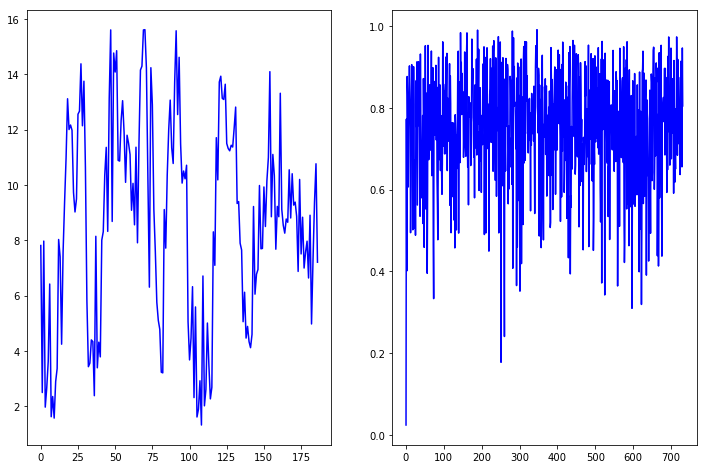

In [46]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.plot(train_loss, color='blue')
ax2.plot(train_accuracy, color='blue')

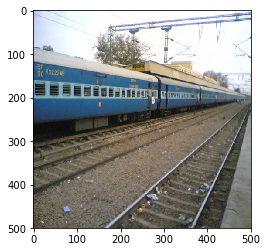

In [47]:
plt.imshow( (train.load_image(train.indices[0]) + mean).astype('uint8'))

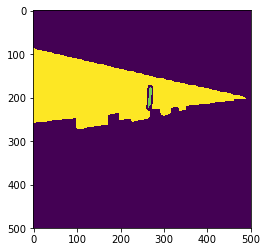

In [48]:
plt.imshow( (train.load_label(train.indices[0])).argmax(axis=2) )

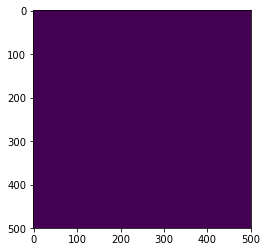

In [49]:
pred = fcn_vgg16.predict(np.array([train.load_image(train.indices[0])]))
plt.imshow( (pred[0]).argmax(axis=2) )